# ADSB Detector and Demodulator

## What is ADSB?

ADSB is a protocol used by commercial aircraft to broadcast their location and other relevant details. The signal is unencrypted, powerful and easy to detect and decode. This makes it a perfect learning opportunity!

In more detail, the ADSB protocol broadcasts aircraft position, velocity and flight number to all receivers within range of the aircraft. Position reports are generated every second and and flight number is reported every five seconds.

The signal is broadcast at 1090 MHz which puts easily in the operable range of most Software Defined Radios. ADSB uses a sample rate of 1e6 bits per second and simple modulation scheme called Pulse Position Modulation.

Pulse Modulation is a very simple method of encoding information onto a signal. In some ways its similar to Morse Code, where information is encoded uses a simple on-off scheme. Pulse Modulation in ADSB uses a version of this same scheme called Manchester Encoding. This simply means, that information is encoded in the transitions between 1 and 0 (on-off) rather than the pulse it itself. This means that the encoding is inherently error correcting and the correct alignment of bits can be easily recovered.

## Why Go Through All This Hassle?

Of course, there is already specialized hardware and software built to process ADSB, so why bother?  Well, this was mostly a professional development exercise aimed at understanding Signal Processing from the ground up.  As such, it's a good representation of what I do daily in my work - from engineering data streams, writing efficient algorithms, conducting data analysis and finally visualizing that data.

## About SDR's

A Software Defined Radio is what allowed me to capture the raw ADSB signal. SDRs are specialized pieces of hardware that capture the electromagnetic spectrum.  In general terms, an SDR has an antenna that responds to electromagnetic fields and an integrated circuit that amplifies and filters a frequency to an intermediate frequency or IF. Here is a picture of the particular SDR I used to capture the data we will be processing:

<div>
<img src="sdrpic.jpg" width="500"/>
</div>

For this project, I wrote a custom Python interface for my SDR to set parameters pythonically.  This interface, which can be viewed in ./radio.py, enables me to start and stop collection, set gain, set center frequency and set the sample rate.  This should be all we need to start collecting some samples!

## Code!

Now that we have defined the problem space, lets collect some samples.  First we take care of our imports - I have marked the modules I wrote with comments

In [24]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import detection # see ./detection.py
import adsb_constants as adsb # see ./adsb_constants.py
import demod # see ./demod.py

## Now, let's visualize some data

Rather than go through the process of collecting new data with the SDR, I have saved off a sample that I collected previously and that I know has data in it.  This ensures that we will have something to detect and decode!

The code below displays a waterfall plot of our data.  First, it uses an algorithm called the Fast Fourier Transform to translate our signal from the time domain to the frequency domain.  Then it does some scaling and shifting and finally plots the result as an image.  This gives us a rough visualization of both time and frequency.  I have only displayed a portion of the collection that has some packets in it.

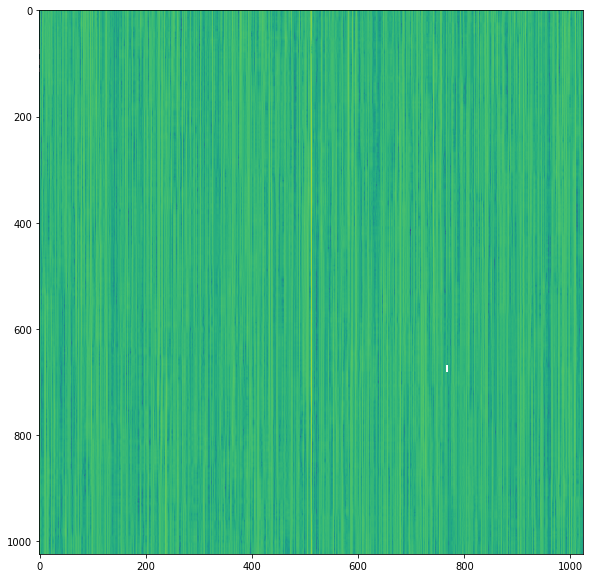

In [25]:
waterfall = []
# Load the pre-collected data
x = np.load('./ADSB_20201216_11:19:42.npy')
for i,slice in enumerate(range(0,len(x),1024)):
    # Run the FFT of size 1024 and normalize
    PSD = (np.abs(np.fft.fft(x[i:i+1024]))/1024)**2
    # Put it in log scale
    PSD_log = 10.0*np.log10(PSD)
    # Shift to baseband
    PSD_shifted = np.fft.fftshift(PSD_log)
    waterfall.append(PSD_shifted)
plt.figure(figsize = (10,10))
# The second FFT block has some data in it
plt.imshow(waterfall[1024:1024*2])
plt.show()

## Detection

We see some energy in the plot above but how do we know that this is ADSB? We can use a match filter against the known training sequence to determine (to some degree of certainty) if the energy is ADSB. First, lets better understand the structure of an ADSB packet by looking at a diagram:

<div>
<img src="adsb-packet.png" width="500"/>
</div>

For the detection portion of this project, we are concerned with the preamble. The preamble contains a unique, fixed pattern of bits that is used to identify this packet as ADSB. If we know this pattern, we can use a match filter to extract possible packets from streams of data.

Match filters are implemented using cross correlation. Below is a helpful visualization of how cross correlation works:

![title](Comparison_convolution_correlation.svg.png)

My implementation of the cross correlation algorithm can be viewed in ./detection.py. The steps are as follows:

- Calculate the standard deviation of the signal and define a threshold
- Identify preamble candidates with power above threshold
- Create a window in the data stream that is the size of the preamble
- Calculate the mean of that window and normalize
- Run cross correlation on window and determine if match to preamble

The cross correlation itself is essentially a implementation of the following function in python:

![title](cc.png)

So, after all that, lets run the detector!

In [26]:
detect = detection.Detection(x,adsb.NOISE_THRESH,adsb.PREAMBLE,adsb.DET_THRESH)
detects = detect.detect()
pprint(detects.keys())

dict_keys([392108, 427407, 896742, 897153, 923580, 935278, 952188, 1197199, 1417710, 1441590, 1484266, 1745446, 2034696, 2237520, 2305788, 2656410, 3021540, 3261605, 3677698, 3709676, 3786923, 3852457, 3965707, 4334621, 5614007, 6062073, 6558175, 6829391, 6867572, 6911343, 6956849, 7001408, 7278310, 7726383, 7742325, 7768295, 7822387, 7909200, 8121706, 8126587, 8241354, 8328283, 8328634, 8750568, 8833271, 8833681, 8881707, 8966602, 8978856, 9580389, 9901934, 9934764])


## Success!

We can see from the above printout that our match filter identified some ADSB training sequences, identified as starting indices in our data stream. Its possible that these are all valid packets or some might be noise. The next step is to run this through our demodulator and see if any resolve.

For this project, I have actually written two separate demodulators. ./demod_2.py is a demodulator that I wrote and ./demod.py is a demodulator that utilizes a library called PyModeS. While extracting some information from an ADSB packet can be relatively easy, extracting the entire packet can be a bit complicated. The version that I wrote only extracts a few fields from the packet including flight id, position and heading. For the purposes of this demo, I will use the PyModeS version which extracts all fields but I will describe the algorithm I wrote in more detail.

The demodulator algorithm starts by using the known size of the preamble and the starting index of the detect to identify where the data portion of the packet begins. Then, assuming a Manchester Encoding, it loops through each sample in the packet and compares it to the next. Since data is encoded in the transitions between bits, we can determine a one or a zero by simply comparing the power of one sample to the next. Now we have our 'hard bits'. To verify that this is indeed and ADSB packet we can use a Cyclic Redundancy Check. A CRC check uses information encoded in the raw data along with a generator sequence to determine if data has been corrupted. Running a CRC check makes sure we have valid data to feed into or decoder. Once we are sure of our hard bits, decoding the message is a simple matter of comparing our bits to the structure of the packet! Lets look at some decoded packets below: 

In [27]:
# Set up a structure to hold our results
planes = {'NULL' : {
            'callsign' : '',
            'odd' : '',
            'even': '',
            'position' : (-1,-1),
            'typecode' : -1,
            'time0' : -1,
            'time1' : -1,
            'speed' : -1,
            'angle': -1,
            'vertical_rate' : -1,
            'speed_type' : '',
            'altitude': -1
        }}
# Over sampled
msgSize = adsb.MSG_BITS*2+adsb.PREAM_LEN
# Set up a row for each detect
msgs = np.zeros(shape=(len(detects),msgSize))
for idx,det in enumerate(detects.keys()):
    b = det # start of message
    e = det + msgSize # end of message
    msgs[idx] = np.abs(x[b:e])
# Run the demodulator
dmd = demod.Demod(msgs,planes)
dmd.demod()
pprint(planes)

{'NULL': {'altitude': -1,
          'angle': -1,
          'callsign': '',
          'even': '',
          'odd': '',
          'position': (-1, -1),
          'speed': -1,
          'speed_type': '',
          'time0': -1,
          'time1': -1,
          'typecode': -1,
          'vertical_rate': -1},
 'a7cc00': {'altitude': -1,
            'angle': -1,
            'callsign': '',
            'even': '',
            'odd': '',
            'position': (-1, -1),
            'speed': -1,
            'speed_type': '',
            'time0': -1,
            'time1': -1,
            'typecode': 19,
            'vertical_rate': -1},
 'a7ed08': {'altitude': 3050,
            'angle': -1,
            'callsign': '',
            'even': '8da7ed085913f06a6d7dfd56580f',
            'odd': '8da7ed08591524027e2b48b9d906',
            'position': (36.62502, -121.9057),
            'speed': -1,
            'speed_type': '',
            'time0': 1642877099.652135,
            'time1': 1642877099.657095

## Display

Ok, we have some demods now organized by flight id. Also, thanks to PyModeS we have the full packet information. One last sanity check on our data would be to plot it. We should make sure that the plane locations make sense relative to our location. Since I am located in Monterey, CA we would expect to see some locations in close proximity.

In [28]:
plots = []
for key in planes.keys():
    if key and planes[key]['position'][0] != -1:
        plots.append({
            'lat':planes[key]['position'][0],
            'lon':planes[key]['position'][1],
            'id':key
        })
fig = px.scatter_geo(plots,lat='lat',lon='lon', hover_name="id")
fig.update_layout(title = 'World map', title_x=0.5)
fig.show()

![title](newplot.png)

# Conclusion

We have successfully collected, detected, demodulated, decoded and visualized ADSB! I chose to present this project because I believe it highlights some of my best skills as an engineer. Namely, being able to dive into a technically complex problem space and quickly derive valuable insights. This project is also a good example of the type of work I have been doing professionally for the last 3 years.

### Goals

While this project was ultimately for professional development and learning, I do hope to eventually present this data to the public in the form of web interface. Future work includes improving the data ingest pipeline and the detector in order to keep up with real time data. I have done some work on a front end interface built with React, but data still needs to be put into a database and an API developed to display data in this interface.

### Challenges

The biggest challenge in this project has been developing a detection algorithm speedy enough to keep up with real-time data. As can be seen in the examples above, for a small subset of data, the detection algorithm took ~30 seconds! This is way to slow for real time. Much work needs to be done in this area before moving on to real-time display of data on a web interface.

### Contributions

As a personal project, I was the only contributor on this project. I do owe much credit to Berkeley materials published on ADSB as well as The 1090 MHz Riddle, a free e-book by Junzui Sun.


# References

The 1090 Megahertz Riddle: https://mode-s.org/decode/

Cross-correlation: https://en.wikipedia.org/wiki/Cross-correlation

ADSB Learning Materials: https://inst.eecs.berkeley.edu/

SDR's and Python: https://pysdr.org/